In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
words = open('names.txt', 'r').read().splitlines()

In [15]:
len(words)

32033

In [184]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [250]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [218]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3) / (30)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [219]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3093
  10000/ 200000: 2.0401
  20000/ 200000: 2.6650
  30000/ 200000: 1.7132
  40000/ 200000: 1.8567
  50000/ 200000: 2.0604
  60000/ 200000: 2.3652
  70000/ 200000: 1.9544
  80000/ 200000: 1.9172
  90000/ 200000: 1.8874
 100000/ 200000: 2.5355
 110000/ 200000: 2.1933
 120000/ 200000: 1.9185
 130000/ 200000: 1.8937
 140000/ 200000: 1.9928
 150000/ 200000: 2.3248
 160000/ 200000: 2.2127
 170000/ 200000: 2.2265
 180000/ 200000: 2.2981
 190000/ 200000: 2.4423


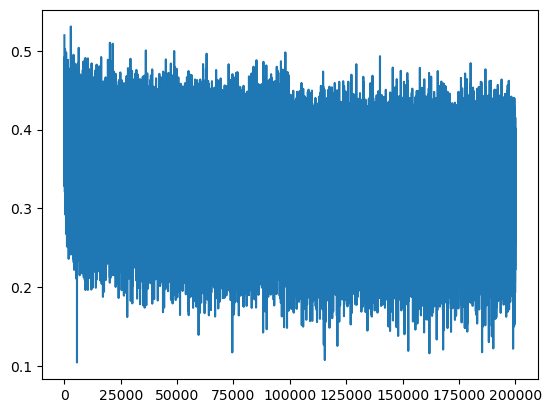

In [200]:
plt.plot(lossi)

In [220]:
@torch.no_grad()

def split_loss(split):
    x,y = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev), 'test': (Xte, Yte)}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.055730104446411
val 2.1107521057128906


In [266]:
# Sampling
for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

scy.
fatiyolle.
kany.
jalayea.
ahleam.
tyronii.
mrannathorr.
jeinomia.
rael.
klaveoreylailynne.
kloissane.
silmelowelle.
mereskanah.
jobeelee.
kaionnakana.
diouhaminyaileyalit.
kayellie.
atlynne.
khfid.
codlee.


In [268]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layers of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
        Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

57851


In [269]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3142
  10000/ 200000: 2.1850
  20000/ 200000: 2.1242
  30000/ 200000: 1.9128
  40000/ 200000: 2.0371
  50000/ 200000: 2.1075
  60000/ 200000: 1.8620
  70000/ 200000: 2.0795
  80000/ 200000: 2.0409
  90000/ 200000: 2.1293
 100000/ 200000: 1.8763
 110000/ 200000: 2.3650
 120000/ 200000: 2.0274
 130000/ 200000: 1.8601
 140000/ 200000: 2.2153
 150000/ 200000: 1.9852
 160000/ 200000: 1.8993
 170000/ 200000: 2.0913
 180000/ 200000: 1.7584
 190000/ 200000: 2.0970


In [270]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0068259239196777
val 2.095669984817505


In [282]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

nartella.
avrian.
johndra.
gordancion.
davon.
takaidrey.
levi.
alexade.
avan.
avrosen.
nichels.
joyalexa.
kaelamarlos.
malayder.
esmerge.
saiah.
kam.
emryn.
aleigh.
lyn.
